<a href="https://colab.research.google.com/github/stbalaji/AIForBusiness/blob/main/02CVUsingNN_EndToEndClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI For Business
# Lesson 02 - End to End Image Classification
# Computer Vision using Neural Network - Illustration of key Steps for Business Level Understanding

## Here are going to use a popular Dataset - Fashion MNIST. This is around set of Categories of Clothes and a Classification problem
- NOTE here we will just keep very essential steps and not explain each line of code. That will be done in the Technical Side of the course. For Business Leaders this has been created to get an broader understanding and appreciation of coding approach / methodology involved.
- Ten Classes of Clothes here are ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Load Libraries, Prepare Datasets - Input values, Target Labels (Class of Cloth like Coat) and Training / Testing splits

In [1]:
from torchvision import datasets
import torch
data_folder = '~/data/FMNIST' # This can be any directory you want
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
device = "cuda" if torch.cuda.is_available() else "cpu"
from torchvision import datasets

data_folder = '~/data/FMNIST' # This can be any directory you want to
# download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets

# to download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)



100%|██████████| 26421880/26421880 [00:01<00:00, 17108285.03it/s]


Extracting /root/data/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 274605.45it/s]


Extracting /root/data/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5025471.98it/s]


Extracting /root/data/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5148373.15it/s]


Extracting /root/data/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



In [2]:
tr_images = fmnist.data
tr_targets = fmnist.targets

In [3]:
unique_values = tr_targets.unique()
print(f'tr_images & tr_targets:\n\tX - {tr_images.shape}\n\tY - {tr_targets.shape}\n\tY - Unique Values : {unique_values}')
print(f'TASK:\n\t{len(unique_values)} class Classification')
print(f'UNIQUE CLASSES:\n\t{fmnist.classes}')

tr_images & tr_targets:
	X - torch.Size([60000, 28, 28])
	Y - torch.Size([60000])
	Y - Unique Values : tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
TASK:
	10 class Classification
UNIQUE CLASSES:
	['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


## Step 2 : Visualize the Data and try to get a sense of the data

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## Note: Each row is a CLASS and Column is a image of that type of Class (eg. Trouser)

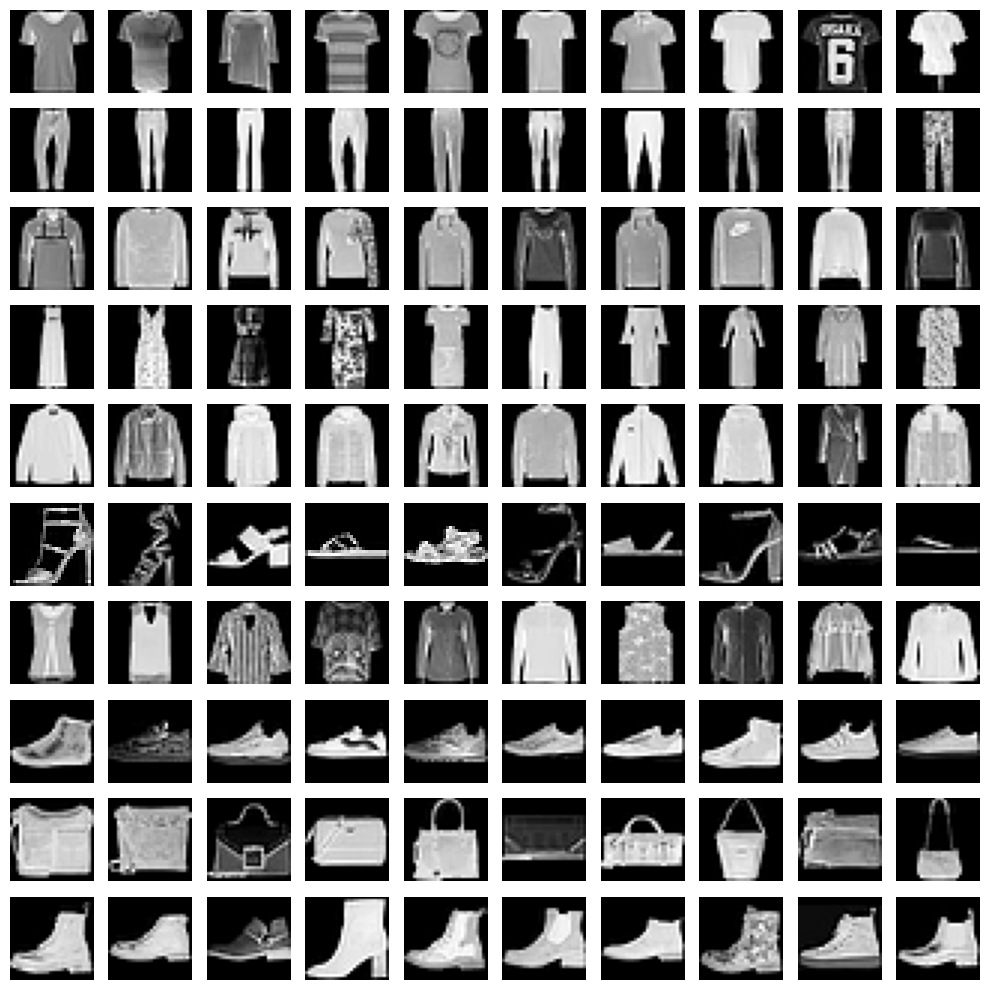

In [5]:
R, C = len(tr_targets.unique()), 10
fig, ax = plt.subplots(R, C, figsize=(10,10))
for label_class, plot_row in enumerate(ax):
    label_x_rows = np.where(tr_targets == label_class)[0]
    for plot_cell in plot_row:
        plot_cell.grid(False); plot_cell.axis('off')
        ix = np.random.choice(label_x_rows)
        x, y = tr_images[ix], tr_targets[ix]
        plot_cell.imshow(x, cmap='gray')
plt.tight_layout()

## Step 3 : Training a Neural Network
- There are set of steps involved. Business leaders to just try to understand the step, input and output

### Define a Class for the Image dataset

In [7]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()
        x = x.view(-1,28*28)
        self.x, self.y = x, y
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

### Define a set of utility functions

In [8]:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    return trn_dl

## Define a Model along with its loss function and optimizer
from torch.optim import SGD
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

## Define a Function that will train a batch of Images

def train_batch(x, y, model, opt, loss_fn):
    model.train() # <- let's hold on to this until we reach dropout section

    # call your model like any python function on your batch of inputs
    prediction = model(x)

    # compute loss
    batch_loss = loss_fn(prediction, y)

    # based on the forward pass in `model(x)` compute all the gradients of

    # 'model.parameters()'
    batch_loss.backward()

    # apply new-weights = f(old-weights, old-weight-gradients) where
    # "f" is the optimizer
    optimizer.step()

    # Flush gradients memory for next batch of calculations
    optimizer.zero_grad()
    return batch_loss.item()

## Define a Function that calculates Accuracy of the given Dataset

@torch.no_grad()
def accuracy(x, y, model):
    model.eval() # <- let's wait till we get to dropout section

    # get the prediction matrix for a tensor of `x` images
    prediction = model(x)

    # compute if the location of maximum in each row coincides
    # with ground truth
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

## Model Definition - Neural Network Model specification details (like loss function, optimizer) are in a function

In [9]:
trn_dl = get_data()
model, loss_fn, optimizer = get_model()

## Model Training - Neural Network Model being trained on 'Traiing dataset or batch'

In [10]:
# Train a Neural Network

losses, accuracies = [], []                         # Define a list
for epoch in range(5):                              # Number of Epochs for Training
    print(epoch)
    epoch_losses, epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)                       # Store the Mean Loss value
    accuracies.append(epoch_accuracy)               # Store the Mean Accuracy value

0
1
2
3
4


## Observe how the Training Accuracy Varies over number of EPOCHS

<ipython-input-11-7c73659c62d9>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


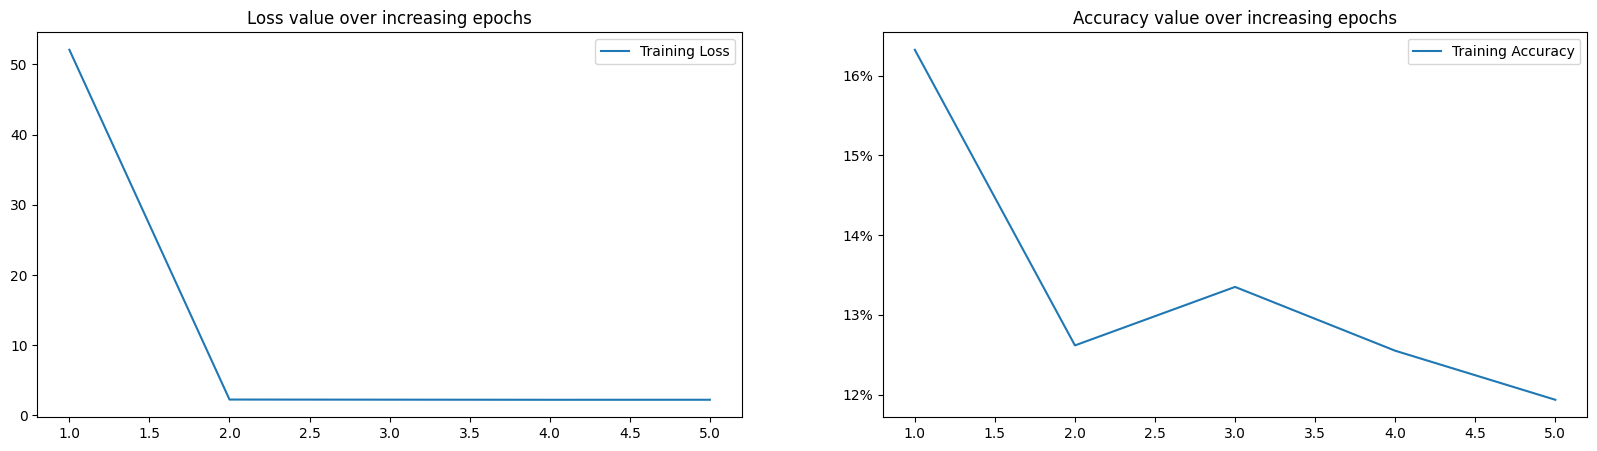

In [11]:
epochs = np.arange(5)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()

## FEW OBSERVATIONS
- Loss did not decrease beyond a number of Epochs.
- This also implies, it is unlikely that the accuracy will increase beyond a point

## ROUND 2 - IMPROVEING MODEL PERFORMANCe - FEATURE SCALING and OTHER TECHNIQUES

### Scaling is ensure variables (input image values) fall or limited to be within a given range (say 0 to 1)



In [12]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()
        x = x/255                # NOTE : This is the additional step added to Scale data. Note: Input pixel values are in the range from 0 to 255 - so dividing by 255 scales values to 0 to 1
        x = x.view(-1,28*28)
        self.x, self.y = x, y
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

### Other Steps are same

In [13]:
trn_dl = get_data()
model, loss_fn, optimizer = get_model()

# Train a Neural Network - On the Scaled Dataset
losses, accuracies = [], []                         # Define a list
for epoch in range(5):                              # Number of Epochs for Training
    print(epoch)
    epoch_losses, epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):       # Loop through multiple batches
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)                       # Store the Mean Loss value
    accuracies.append(epoch_accuracy)               # Store the Mean Accuracy value

0
1
2
3
4


<ipython-input-14-7c73659c62d9>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


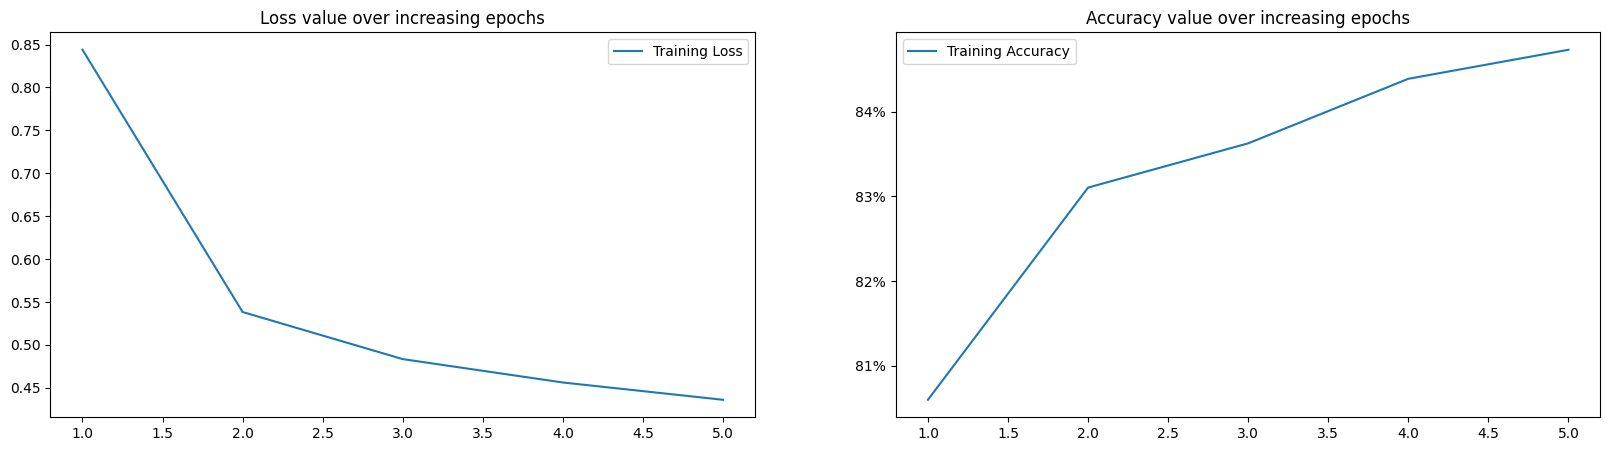

In [14]:
epochs = np.arange(5)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()

In [ ]:
## FEW OBSERVATIONS
- Loss consistency reduced and Training Accuracey consistency increared - reaching 85% of Accuracy level

# RESON Why Scaling helps has to do with use and understanding of Sigmoid function
- When Weight values are more than 0.1 the Sigmoid values don't vary for increasing weight values (i.e. when input values are between 0 and 255)
- When the Weight values change by extremely smaller amount, Sigmoid values change by little.

ESSENTIALLY SIGMOID VALUES DON'T CHANGE CONSIDERABLY UNLESS THE WEIGHT values are very small. So scaling applied.

## THE ABOVE IS An EXAMPLE. We can apply other techinques for better performance like
*   A) Batch Size e.g. use 32 --> Change to large number like 10K
*   B) LOSS OPTIMIZER
*   C) INCREASE NUMBER OF EPOCH
*   D) VARY THE LEARNING RATE (LR)
*   E) BUILDING A DEEPER NEURAL NETWORK By VARIOUS THE LAYERs SIZE
*   F) BATCH NORMALIZATION


## ADDITIONAL CONCEPTS of
- Dropout (Dropping Layers)
- Regularization

# CLASSIFYING A NEW or UNSEEN IMAGE

Text(0.5, 1.0, 'Trouser')

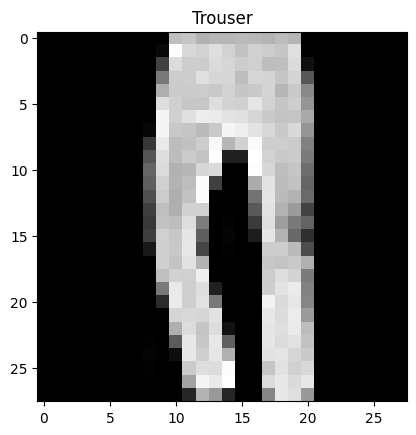

In [15]:
#ix = np.random.randint(len(tr_images))
ix = 24300
plt.imshow(tr_images[ix], cmap='gray')
plt.title(fmnist.classes[tr_targets[ix]])

OVERFITTING : Keep in mind the concept of Overfitting
- We want our Model to Learn but also be able to Generalize as much on Unseen data.
- Make sure the Accuracy on Training and Validation sets are not high / similar